# Configure Gradient Precision with Batch Size

Neural networks are trained using gradient descent, where the estimate of the error used to update the weights is calculated based on a subset of the training dataset. The number of examples from the training dataset used in the estimate of the error gradient is called the batch size and is an important hyperparameter that influences the dynamics of the learning algorithm. It is important to explore the dynamics of your model to ensure that you're getting the most out of it. In this tutorial, you will discover three different favors of gradient descent and how to explore and diagnose the effect of batch size on the learning process. After completing this tutorial, you will know:
* Batch size controls the accuracy of the estimate of the error gradient when training neural networks.
* Batch, Stochastic, and Minibatch gradient descent are the three main favors of the learning algorithm.
* There is a tension between batch size and the speed and stability of the learning process.

## Batch Size and Gradient Descent

Neural networks are trained using the stochastic gradient descent optimization algorithm. This involves using the model's current state to predict, compare the prediction to the actual values, and use the difference as an estimate of the error gradient. This error gradient is then used to update the model weights, and the process is repeated. The error gradient is a statistical estimate. The more training examples used in the estimate, the more accurate this estimate will be and the more likely that the weights of the network will be adjusted to improve the model's performance. The improved estimate of the error gradient comes at the computational cost of using the model to make many more predictions before the estimate can be calculated. In turn, the weights updated.

Alternately, using fewer examples results in a less accurate estimate of the error gradient that is highly dependent on the specific training examples used. This results in a noisy estimate that, in turn, results in noisy updates to the model weights, e.g., many updates with perhaps quite different estimates of the error gradient. Nevertheless, these noisy updates can result in faster learning and sometimes a more robust model.

The number of training examples used in the estimate of the error gradient is a hyperparameter for the learning algorithm called the batch size, or simply the batch. A batch size of 32 means that 32 samples from the training dataset will be used to estimate the error gradient before the model weights are updated. One training epoch means that the learning algorithm has made one pass through the training dataset (using every example once), where examples were separated into randomly selected batch size groups. Historically, a training algorithm where the batch size is set to the total number of training examples is called batch gradient descent, and a training algorithm where the batch size is set to 1 training example is called stochastic gradient descent or online gradient descent. A configuration of the batch size anywhere in between (e.g., more than 1 example and less than the number of examples in the training dataset) is called minibatch gradient descent.

* **Batch Gradient Descent**. Batch size is set to the total number of examples in the training dataset.
* **Stochastic Gradient Descent**. The batch size is set to one.
* **Minibatch Gradient Descent**. Batch size is set to more than one and less than the total number of examples in the training dataset.

For shorthand, the algorithm is often referred to as stochastic gradient descent regardless of the batch size. Given that very large datasets are often used to train deep learning neural networks, the batch size is rarely set to the size of the training dataset. Smaller batch sizes are used for two main reasons:

* Smaller batch sizes are noisy, offering a regularizing effect and lower generalization error.
* Smaller batch sizes make it easier to fit one batch's worth of training data in memory (i.e., when using a GPU with access to less local memory than system RAM).

A third reason is that the batch size is often set at something small, such as 32 examples, and is not tuned by the practitioner. Small batch sizes such as 32 do work well generally. Nevertheless, the batch size impacts how quickly a model learns and the stability of the learning process. It is an important hyperparameter that should be well understood and tuned by the deep learning practitioner.

## Batch Size Case Study

This section will demonstrate how to use gradient descent batch size to control learning with an MLP on a simple classification problem. This example provides a template for exploring batch size with your neural network for classification and regression problems.

### Multiclass Classification Problem

We will use a small multiclass classification problem as the basis to demonstrate the effect of batch size on learning. The scikit-learn class provides the make blobs() function that can be used to create a multiclass classification problem with the prescribed number of samples, input variables, classes, and variance of samples within a class. The problem can be configured to have two input variables (representing the x and y coordinates of the points) and a standard deviation of 2.0 for points within each group. We will use the same random state (seed for the pseudorandom number generator) always to get the same data points.

```
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
```

The results are the input and output elements of a dataset that we can model. To get a feeling for the complexity of the problem, we can plot each point on a two-dimensional scatter plot and color each point by class value. The complete example is listed below.

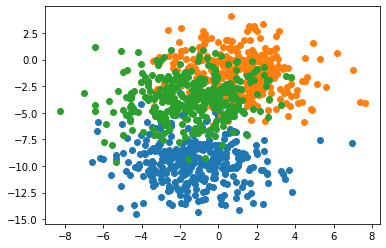

In [1]:
import numpy
import os
import random
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# fix random seed for reproducibility
seed = 2

os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
numpy.random.seed(seed)
tf.random.set_seed(seed)

# scatter plot of blobs dataset
from numpy import where
from sklearn.datasets import make_blobs
from matplotlib import pyplot

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=seed)

# scatter plot for each class value
for class_value in range(3):
    # select indices of points with the class label
    row_ix = where(y == class_value)
    
    # scatter plot for points with a different color
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])

    # show plot
pyplot.show()

Running the example creates a scatter plot of the entire dataset. We can see that the standard deviation of 2.0 means that the classes are not linearly separable (separable by a line), causing many ambiguous points. This is desirable as it means that the problem is non-trivial and will allow a neural network model to find many different good enough candidate solutions.

### MLP Fit With Batch Gradient Descent

We can develop a Multilayer Perceptron model (MLP) to address the multiclass classification problem described in the previous section and train it using batch gradient descent. Firstly, we need to one-hot encode the target variable, transforming the integer class values into binary vectors. This will allow the model to predict the probability of each example belonging to each of the three classes, providing more nuance in the predictions and context when training the model.

```
# one hot encode output variable
y = to_categorical(y)
```

Next, we will split the training dataset of 1,000 examples into a train and test dataset with 500 examples each. This even split will allow us to evaluate and compare different configurations of the batch size on the model and its performance.

```
# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
return trainX, trainy, testX, testy
```

We will define an MLP model with an input layer that expects two input variables for the two variables in the dataset. The model will have a single hidden layer with 50 nodes and a rectified linear activation function and He random weight initialization. Finally, the output layer has three nodes to make predictions for the three classes and a softmax activation function.

```
# define model
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(3, activation='softmax'))
```

We will optimize the model with stochastic gradient descent and use categorical cross-entropy to calculate the model's error during training. In this example, we will use batch gradient descent, meaning that the batch size will be set to the size of the training dataset. The model will fit 200 training epochs, and the test dataset will be used as the validation set to monitor the performance of the model on a holdout set during training. The effect will be more time between weight updates, and we would expect faster training than other batch sizes and more stable estimates of the gradient, which should result in a more stable performance of the model during training.

```
# compile model
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0, batch_size=len(trainX))
```

Once the model is fit, the performance is evaluated and reported on the train and test datasets.

```
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
```

A line plot is created showing the train and test set accuracy of the model for each training epoch. These learning curves indicate three things:
* how quickly the model learns the problem
* how well it has learned the problem
* how noisy the updates were to the model during training

Tying these elements together, the complete example is listed below.

In [2]:
#Plot of images as baseline for comparison
from tensorflow.keras.utils import to_categorical

# prepare multiclass classification dataset
def create_dataset():
    # generate 2d classification dataset
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=seed)
    
    # one hot encode output variable
    y = to_categorical(y)
    
    # split into train and test
    n_train = 500
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]
    
    return trainX, trainy, testX, testy

# fit model with given number of nodes, returns test set accuracy
def evaluate_model(n_nodes, trainX, trainy, testX, testy, batch_size, learning_rate = 0.01):
    # configure the model based on the data
    n_input, n_classes = trainX.shape[1], testy.shape[1]

    # define model
    model = Sequential()
    model.add(Dense(n_nodes, input_dim=n_input, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(n_classes, activation='softmax'))

    # compile model
    opt = SGD(lr=learning_rate, momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    # fit model on train set
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=1, batch_size=batch_size)

    # evaluate model on test set
    _, train_acc = model.evaluate(trainX, trainy, verbose=1)
    _, test_acc = model.evaluate(testX, testy, verbose=1)
    
    return history, train_acc, test_acc

# prepare dataset
trainX, trainy, testX, testy = create_dataset()
history, train_acc, test_acc = evaluate_model(50, trainX, trainy, testX, testy, batch_size = len(trainX))

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Epoch 1/200
1/1 [==============================] - 1s 817ms/step - loss: 7.4486 - accuracy: 0.3140 - val_loss: 2.1244 - val_accuracy: 0.2720
Epoch 2/200
1/1 [==============================] - 0s 26ms/step - loss: 2.1159 - accuracy: 0.2900 - val_loss: 5.0237 - val_accuracy: 0.3260
Epoch 3/200
1/1 [==============================] - 0s 26ms/step - loss: 5.1869 - accuracy: 0.3420 - val_loss: 6.2291 - val_accuracy: 0.3260
Epoch 4/200
1/1 [==============================] - 0s 27ms/step - loss: 6.4922 - accuracy: 0.3420 - val_loss: 5.2320 - val_accuracy: 0.3260
Epoch 5/200
1/1 [==============================] - 0s 26ms/step - loss: 5.5168 - accuracy: 0.3420 - val_loss: 2.3969 - val_accuracy: 0.3700
Epoch 6/200
1/1 [==============================] - 0s 26ms/step - loss: 2.6128 - accuracy: 0.3580 - val_loss: 3.4920 - val_accuracy: 0.5120
Epoch 7/200
1/1 [==============================] - 0s 26ms/step - loss: 3.7005 - accuracy: 0.4800 - val_loss: 3.9491 - val_accuracy: 0.5240
Epoch 8/200
1/1 [==

1/1 [==============================] - 0s 96ms/step - loss: 0.6016 - accuracy: 0.7480 - val_loss: 0.5922 - val_accuracy: 0.7960
Epoch 60/200
1/1 [==============================] - 0s 30ms/step - loss: 0.6094 - accuracy: 0.7480 - val_loss: 0.5626 - val_accuracy: 0.7680
Epoch 61/200
1/1 [==============================] - 0s 28ms/step - loss: 0.5819 - accuracy: 0.7420 - val_loss: 0.5592 - val_accuracy: 0.7560
Epoch 62/200
1/1 [==============================] - 0s 29ms/step - loss: 0.5778 - accuracy: 0.7300 - val_loss: 0.5660 - val_accuracy: 0.7620
Epoch 63/200
1/1 [==============================] - 0s 26ms/step - loss: 0.5766 - accuracy: 0.7380 - val_loss: 0.5743 - val_accuracy: 0.7680
Epoch 64/200
1/1 [==============================] - 0s 27ms/step - loss: 0.5803 - accuracy: 0.7440 - val_loss: 0.5668 - val_accuracy: 0.7640
Epoch 65/200
1/1 [==============================] - 0s 30ms/step - loss: 0.5740 - accuracy: 0.7400 - val_loss: 0.5649 - val_accuracy: 0.7680
Epoch 66/200
1/1 [========

1/1 [==============================] - 0s 26ms/step - loss: 0.4997 - accuracy: 0.8000 - val_loss: 0.4938 - val_accuracy: 0.8200
Epoch 118/200
1/1 [==============================] - 0s 25ms/step - loss: 0.4989 - accuracy: 0.8020 - val_loss: 0.4926 - val_accuracy: 0.8220
Epoch 119/200
1/1 [==============================] - 0s 26ms/step - loss: 0.4981 - accuracy: 0.8020 - val_loss: 0.4916 - val_accuracy: 0.8220
Epoch 120/200
1/1 [==============================] - 0s 28ms/step - loss: 0.4973 - accuracy: 0.8020 - val_loss: 0.4910 - val_accuracy: 0.8220
Epoch 121/200
1/1 [==============================] - 0s 26ms/step - loss: 0.4965 - accuracy: 0.8020 - val_loss: 0.4905 - val_accuracy: 0.8220
Epoch 122/200
1/1 [==============================] - 0s 27ms/step - loss: 0.4956 - accuracy: 0.8000 - val_loss: 0.4897 - val_accuracy: 0.8200
Epoch 123/200
1/1 [==============================] - 0s 27ms/step - loss: 0.4949 - accuracy: 0.7980 - val_loss: 0.4887 - val_accuracy: 0.8200
Epoch 124/200
1/1 [=

Epoch 175/200
1/1 [==============================] - 0s 28ms/step - loss: 0.4601 - accuracy: 0.8080 - val_loss: 0.4573 - val_accuracy: 0.8380
Epoch 176/200
1/1 [==============================] - 0s 26ms/step - loss: 0.4596 - accuracy: 0.8080 - val_loss: 0.4572 - val_accuracy: 0.8360
Epoch 177/200
1/1 [==============================] - 0s 26ms/step - loss: 0.4590 - accuracy: 0.8100 - val_loss: 0.4564 - val_accuracy: 0.8380
Epoch 178/200
1/1 [==============================] - 0s 26ms/step - loss: 0.4585 - accuracy: 0.8080 - val_loss: 0.4557 - val_accuracy: 0.8380
Epoch 179/200
1/1 [==============================] - 0s 26ms/step - loss: 0.4580 - accuracy: 0.8080 - val_loss: 0.4556 - val_accuracy: 0.8360
Epoch 180/200
1/1 [==============================] - 0s 26ms/step - loss: 0.4574 - accuracy: 0.8100 - val_loss: 0.4550 - val_accuracy: 0.8360
Epoch 181/200
1/1 [==============================] - 0s 100ms/step - loss: 0.4568 - accuracy: 0.8100 - val_loss: 0.4544 - val_accuracy: 0.8360
Epoch

Running the example first reports the performance of the model on the train and test datasets.

**Note**: Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that performance was similar between the train and test sets with 81% and 83%, respectively.

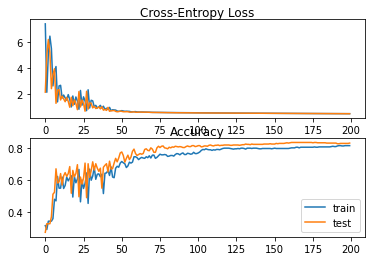

In [3]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

A line plot of model loss and classification accuracy on the train (blue) and test (orange) dataset is created. We can see that the model is relatively slow to learn this problem, converging on a solution after about 100 epochs, after which changes in model performance are minor.

### MLP Fit With Stochastic Gradient Descent

The example of batch gradient descent from the previous section can be updated instead of stochastic gradient descent. This requires changing the batch size from the size of the training dataset to 1.

```
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0, batch_size=1)
```

Stochastic gradient descent requires that the model make a prediction and have the weights updated for each training example. This has the effect of dramatically slowing down the training process as compared to batch gradient descent. This change expects that the model learns faster (e.g., in terms of the learning curve) and that changes to the model are noisy, resulting, in turn, in noisy performance over training epochs. The complete example with this change is listed below.

In [4]:
# prepare dataset
trainX, trainy, testX, testy = create_dataset()
history, train_acc, test_acc = evaluate_model(50, trainX, trainy, testX, testy, batch_size = 1)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Epoch 1/200
500/500 [==============================] - 1s 2ms/step - loss: 3.4254 - accuracy: 0.4299 - val_loss: 0.9674 - val_accuracy: 0.5900
Epoch 2/200
500/500 [==============================] - 1s 1ms/step - loss: 1.0382 - accuracy: 0.5435 - val_loss: 0.9413 - val_accuracy: 0.5200
Epoch 3/200
500/500 [==============================] - 1s 1ms/step - loss: 1.0127 - accuracy: 0.4958 - val_loss: 0.9922 - val_accuracy: 0.4580
Epoch 4/200
500/500 [==============================] - 1s 1ms/step - loss: 1.0265 - accuracy: 0.4134 - val_loss: 1.0437 - val_accuracy: 0.4080
Epoch 5/200
500/500 [==============================] - 1s 1ms/step - loss: 0.9453 - accuracy: 0.4762 - val_loss: 1.0550 - val_accuracy: 0.5280
Epoch 6/200
500/500 [==============================] - 1s 1ms/step - loss: 0.9487 - accuracy: 0.4856 - val_loss: 0.9530 - val_accuracy: 0.5080
Epoch 7/200
500/500 [==============================] - 1s 1ms/step - loss: 0.9353 - accuracy: 0.4988 - val_loss: 0.9291 - val_accuracy: 0.5100

Epoch 58/200
500/500 [==============================] - 1s 1ms/step - loss: 0.9419 - accuracy: 0.5397 - val_loss: 1.0112 - val_accuracy: 0.5720
Epoch 59/200
500/500 [==============================] - 1s 1ms/step - loss: 1.0301 - accuracy: 0.5525 - val_loss: 0.9300 - val_accuracy: 0.5020
Epoch 60/200
500/500 [==============================] - 1s 1ms/step - loss: 0.9347 - accuracy: 0.5236 - val_loss: 0.9552 - val_accuracy: 0.5720
Epoch 61/200
500/500 [==============================] - 1s 1ms/step - loss: 0.9275 - accuracy: 0.5518 - val_loss: 0.8227 - val_accuracy: 0.5900
Epoch 62/200
500/500 [==============================] - 1s 1ms/step - loss: 0.7878 - accuracy: 0.6130 - val_loss: 0.7590 - val_accuracy: 0.6520
Epoch 63/200
500/500 [==============================] - 1s 1ms/step - loss: 0.8106 - accuracy: 0.6127 - val_loss: 0.7357 - val_accuracy: 0.6740
Epoch 64/200
500/500 [==============================] - 1s 1ms/step - loss: 0.8975 - accuracy: 0.5627 - val_loss: 0.9770 - val_accuracy:

Epoch 115/200
500/500 [==============================] - 1s 1ms/step - loss: 0.9229 - accuracy: 0.4841 - val_loss: 0.8547 - val_accuracy: 0.5940
Epoch 116/200
500/500 [==============================] - 1s 1ms/step - loss: 0.9414 - accuracy: 0.5546 - val_loss: 0.7332 - val_accuracy: 0.7640
Epoch 117/200
500/500 [==============================] - 1s 1ms/step - loss: 0.8062 - accuracy: 0.6693 - val_loss: 0.9201 - val_accuracy: 0.4300
Epoch 118/200
500/500 [==============================] - 1s 1ms/step - loss: 0.8297 - accuracy: 0.6262 - val_loss: 0.6692 - val_accuracy: 0.7360
Epoch 119/200
500/500 [==============================] - 1s 1ms/step - loss: 0.8299 - accuracy: 0.6715 - val_loss: 0.8985 - val_accuracy: 0.6920
Epoch 120/200
500/500 [==============================] - 1s 1ms/step - loss: 0.8457 - accuracy: 0.6679 - val_loss: 0.8448 - val_accuracy: 0.5980
Epoch 121/200
500/500 [==============================] - 1s 1ms/step - loss: 0.9077 - accuracy: 0.5441 - val_loss: 0.8582 - val_ac

500/500 [==============================] - 1s 1ms/step - loss: 1.0754 - accuracy: 0.5648 - val_loss: 0.7959 - val_accuracy: 0.7380
Epoch 172/200
500/500 [==============================] - 1s 1ms/step - loss: 0.7232 - accuracy: 0.6877 - val_loss: 0.8006 - val_accuracy: 0.6640
Epoch 173/200
500/500 [==============================] - 1s 1ms/step - loss: 0.8272 - accuracy: 0.6138 - val_loss: 0.8635 - val_accuracy: 0.6540
Epoch 174/200
500/500 [==============================] - 1s 1ms/step - loss: 0.7485 - accuracy: 0.6733 - val_loss: 1.1686 - val_accuracy: 0.6020
Epoch 175/200
500/500 [==============================] - 1s 1ms/step - loss: 0.8829 - accuracy: 0.6010 - val_loss: 0.9993 - val_accuracy: 0.4220
Epoch 176/200
500/500 [==============================] - 1s 1ms/step - loss: 0.8056 - accuracy: 0.6186 - val_loss: 0.9646 - val_accuracy: 0.5640
Epoch 177/200
500/500 [==============================] - 1s 1ms/step - loss: 0.9230 - accuracy: 0.5694 - val_loss: 0.8403 - val_accuracy: 0.6160

Running the example first reports the performance of the model on the train and test datasets.

**Note**: Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that performance was similar between the train and test sets, around 50% accuracy, but was dramatically worse (about 30 percentage points) than using batch gradient descent. At least for this problem and the chosen model and model configuration, stochastic (online) gradient descent is not appropriate.

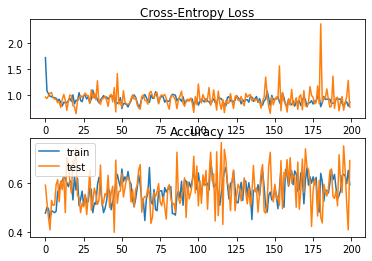

In [5]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

A line plot of model loss and classification accuracy on the train (blue) and test (orange) dataset is created. The plot shows the unstable nature of the training process with the chosen configuration. The poor performance and erratic changes to the model suggest that the learning rate used to update weights after each training example may be too large and that a smaller learning rate may make the learning process more stable.

We can test this by re-running the model fit with stochastic gradient descent and a smaller learning rate. For example, we can drop the learning rate by order of magnitude from 0.01 to 0.001.

In [6]:
# prepare dataset
trainX, trainy, testX, testy = create_dataset()
history, train_acc, test_acc = evaluate_model(50, trainX, trainy, testX, testy, batch_size = 1, learning_rate=0.001)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Epoch 1/200
500/500 [==============================] - 1s 1ms/step - loss: 3.0389 - accuracy: 0.4753 - val_loss: 0.8267 - val_accuracy: 0.7140
Epoch 2/200
500/500 [==============================] - 1s 1ms/step - loss: 1.1592 - accuracy: 0.6064 - val_loss: 0.5616 - val_accuracy: 0.7480
Epoch 3/200
500/500 [==============================] - 1s 1ms/step - loss: 0.8071 - accuracy: 0.7044 - val_loss: 2.5876 - val_accuracy: 0.5200
Epoch 4/200
500/500 [==============================] - 1s 1ms/step - loss: 0.7581 - accuracy: 0.7146 - val_loss: 0.4728 - val_accuracy: 0.8240
Epoch 5/200
500/500 [==============================] - 1s 1ms/step - loss: 0.5211 - accuracy: 0.7878 - val_loss: 0.5372 - val_accuracy: 0.7460
Epoch 6/200
500/500 [==============================] - 1s 1ms/step - loss: 0.5379 - accuracy: 0.7834 - val_loss: 0.4633 - val_accuracy: 0.8260
Epoch 7/200
500/500 [==============================] - 1s 1ms/step - loss: 0.5127 - accuracy: 0.7919 - val_loss: 0.4480 - val_accuracy: 0.8160

Epoch 58/200
500/500 [==============================] - 1s 2ms/step - loss: 0.4193 - accuracy: 0.8196 - val_loss: 0.4505 - val_accuracy: 0.8280
Epoch 59/200
500/500 [==============================] - 1s 1ms/step - loss: 0.4154 - accuracy: 0.8126 - val_loss: 0.4213 - val_accuracy: 0.8300
Epoch 60/200
500/500 [==============================] - 1s 1ms/step - loss: 0.3627 - accuracy: 0.8525 - val_loss: 0.4755 - val_accuracy: 0.8040
Epoch 61/200
500/500 [==============================] - 1s 1ms/step - loss: 0.4166 - accuracy: 0.8303 - val_loss: 0.4454 - val_accuracy: 0.8300
Epoch 62/200
500/500 [==============================] - 1s 1ms/step - loss: 0.4111 - accuracy: 0.8183 - val_loss: 0.4194 - val_accuracy: 0.8180
Epoch 63/200
500/500 [==============================] - 1s 1ms/step - loss: 0.4373 - accuracy: 0.8038 - val_loss: 0.4614 - val_accuracy: 0.8120
Epoch 64/200
500/500 [==============================] - 1s 1ms/step - loss: 0.4564 - accuracy: 0.7911 - val_loss: 0.4282 - val_accuracy:

Epoch 115/200
500/500 [==============================] - 1s 1ms/step - loss: 0.3724 - accuracy: 0.8406 - val_loss: 0.4647 - val_accuracy: 0.8060
Epoch 116/200
500/500 [==============================] - 1s 1ms/step - loss: 0.3927 - accuracy: 0.8402 - val_loss: 0.4388 - val_accuracy: 0.8260
Epoch 117/200
500/500 [==============================] - 1s 1ms/step - loss: 0.3624 - accuracy: 0.8431 - val_loss: 0.4530 - val_accuracy: 0.8140
Epoch 118/200
500/500 [==============================] - 1s 1ms/step - loss: 0.4454 - accuracy: 0.8096 - val_loss: 0.4575 - val_accuracy: 0.8100
Epoch 119/200
500/500 [==============================] - 1s 1ms/step - loss: 0.3905 - accuracy: 0.8278 - val_loss: 0.4333 - val_accuracy: 0.8300
Epoch 120/200
500/500 [==============================] - 1s 1ms/step - loss: 0.4126 - accuracy: 0.7977 - val_loss: 0.4403 - val_accuracy: 0.8260
Epoch 121/200
500/500 [==============================] - 1s 1ms/step - loss: 0.3895 - accuracy: 0.8400 - val_loss: 0.4436 - val_ac

500/500 [==============================] - 1s 1ms/step - loss: 0.4077 - accuracy: 0.8207 - val_loss: 0.4710 - val_accuracy: 0.8180
Epoch 172/200
500/500 [==============================] - 1s 1ms/step - loss: 0.3439 - accuracy: 0.8399 - val_loss: 0.4492 - val_accuracy: 0.8240
Epoch 173/200
500/500 [==============================] - 1s 1ms/step - loss: 0.3403 - accuracy: 0.8678 - val_loss: 0.4469 - val_accuracy: 0.8160
Epoch 174/200
500/500 [==============================] - 1s 1ms/step - loss: 0.4033 - accuracy: 0.8245 - val_loss: 0.4539 - val_accuracy: 0.8260
Epoch 175/200
500/500 [==============================] - 1s 1ms/step - loss: 0.3832 - accuracy: 0.8433 - val_loss: 0.4667 - val_accuracy: 0.8180
Epoch 176/200
500/500 [==============================] - 1s 1ms/step - loss: 0.3656 - accuracy: 0.8435 - val_loss: 0.4518 - val_accuracy: 0.8220
Epoch 177/200
500/500 [==============================] - 1s 1ms/step - loss: 0.3603 - accuracy: 0.8269 - val_loss: 0.4364 - val_accuracy: 0.8260

Running this example tells a very different story.

**Note**: Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

The reported performance is greatly improved, achieving classification accuracy on the train and test sets on par with fit using batch gradient descent.

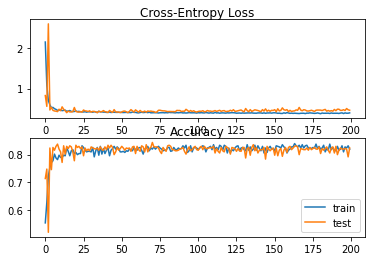

In [7]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

The line plot shows the expected behavior. Namely, the model rapidly learns the problem compared to batch gradient descent, leaping up to about 80% accuracy in about 25 epochs rather than the 100 epochs seen when using batch gradient descent. We could have stopped training at epoch 50 instead of epoch 200 due to the faster training. This is not surprising. With batch gradient descent, 100 epochs involved 100 estimates of error and 100 weight updates. In stochastic gradient descent, 25 epochs involved (500 x 25) or 12,500 weight updates, providing more than 10-times more feedback, albeit more noisy feedback, about how to improve the model.

The line plot also shows that train and test performance remain comparable during training, compared to the dynamics with batch gradient descent, where the performance on the test set was slightly better and remained so throughout training. Unlike batch gradient descent, we can see that the noisy updates result in noisy performance throughout the duration of training. This variance in the model means that it may be challenging to choose which model to use as the final model instead of batch gradient descent, where performance is stabilized because the model has converged.

This example highlights the important relationship between batch size and the learning rate. Namely, more noisy updates to the model require a smaller learning rate, whereas less noisy, more accurate estimates of the error gradient may be applied to the model more liberally. We can summarize this as follows:
* **Batch Gradient Descent**: Use a relatively larger learning rate and more training epochs.
* **Stochastic Gradient Descent**: Use a relatively smaller learning rate and fewer training epochs.

Mini-batch gradient descent provides an alternative approach.

### MLP Fit With Minibatch Gradient Descent

An alternative to using stochastic gradient descent and tuning the learning rate is to hold the learning rate constant and to change the batch size. In effect, we specify the rate of learning or amount of change to apply to the weights each time we estimate the error gradient and vary the gradient-based accuracy on the number of samples used to estimate it. Holding the learning rate at 0.01 as we did with batch gradient descent, we can set the batch size to 32, a widely adopted default batch size.

In [8]:
# prepare dataset
trainX, trainy, testX, testy = create_dataset()
history, train_acc, test_acc = evaluate_model(50, trainX, trainy, testX, testy, batch_size = 32, learning_rate=0.01)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Epoch 1/200
16/16 [==============================] - 0s 9ms/step - loss: 3.6356 - accuracy: 0.4304 - val_loss: 1.4490 - val_accuracy: 0.7020
Epoch 2/200
16/16 [==============================] - 0s 3ms/step - loss: 1.9666 - accuracy: 0.6078 - val_loss: 1.2587 - val_accuracy: 0.6060
Epoch 3/200
16/16 [==============================] - 0s 3ms/step - loss: 2.7057 - accuracy: 0.5562 - val_loss: 2.5045 - val_accuracy: 0.4380
Epoch 4/200
16/16 [==============================] - 0s 3ms/step - loss: 1.9946 - accuracy: 0.5661 - val_loss: 1.1981 - val_accuracy: 0.6940
Epoch 5/200
16/16 [==============================] - 0s 4ms/step - loss: 1.1936 - accuracy: 0.6396 - val_loss: 0.9816 - val_accuracy: 0.6500
Epoch 6/200
16/16 [==============================] - 0s 4ms/step - loss: 1.0592 - accuracy: 0.6115 - val_loss: 1.1111 - val_accuracy: 0.6880
Epoch 7/200
16/16 [==============================] - 0s 3ms/step - loss: 0.7817 - accuracy: 0.7204 - val_loss: 0.5203 - val_accuracy: 0.7980
Epoch 8/200
1

Epoch 59/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4365 - accuracy: 0.8027 - val_loss: 0.4078 - val_accuracy: 0.8300
Epoch 60/200
16/16 [==============================] - 0s 3ms/step - loss: 0.3837 - accuracy: 0.8440 - val_loss: 0.4229 - val_accuracy: 0.8300
Epoch 61/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4250 - accuracy: 0.8361 - val_loss: 0.4284 - val_accuracy: 0.8220
Epoch 62/200
16/16 [==============================] - 0s 4ms/step - loss: 0.4629 - accuracy: 0.7899 - val_loss: 0.4230 - val_accuracy: 0.8380
Epoch 63/200
16/16 [==============================] - 0s 8ms/step - loss: 0.4700 - accuracy: 0.7948 - val_loss: 0.4247 - val_accuracy: 0.8220
Epoch 64/200
16/16 [==============================] - 0s 4ms/step - loss: 0.4921 - accuracy: 0.7738 - val_loss: 0.4062 - val_accuracy: 0.8260
Epoch 65/200
16/16 [==============================] - 0s 4ms/step - loss: 0.3846 - accuracy: 0.8451 - val_loss: 0.4163 - val_accuracy: 0.8340
Epoch 

16/16 [==============================] - 0s 4ms/step - loss: 0.4009 - accuracy: 0.8330 - val_loss: 0.4055 - val_accuracy: 0.8200
Epoch 117/200
16/16 [==============================] - 0s 4ms/step - loss: 0.3743 - accuracy: 0.8474 - val_loss: 0.4038 - val_accuracy: 0.8300
Epoch 118/200
16/16 [==============================] - 0s 4ms/step - loss: 0.4538 - accuracy: 0.8132 - val_loss: 0.4148 - val_accuracy: 0.8180
Epoch 119/200
16/16 [==============================] - 0s 4ms/step - loss: 0.3962 - accuracy: 0.8280 - val_loss: 0.4167 - val_accuracy: 0.8260
Epoch 120/200
16/16 [==============================] - 0s 4ms/step - loss: 0.4061 - accuracy: 0.8292 - val_loss: 0.4276 - val_accuracy: 0.8200
Epoch 121/200
16/16 [==============================] - 0s 4ms/step - loss: 0.3895 - accuracy: 0.8332 - val_loss: 0.4109 - val_accuracy: 0.8240
Epoch 122/200
16/16 [==============================] - 0s 4ms/step - loss: 0.3552 - accuracy: 0.8367 - val_loss: 0.4296 - val_accuracy: 0.8220
Epoch 123/200

16/16 [==============================] - 0s 4ms/step - loss: 0.3413 - accuracy: 0.8799 - val_loss: 0.4199 - val_accuracy: 0.8180
Epoch 174/200
16/16 [==============================] - 0s 4ms/step - loss: 0.3788 - accuracy: 0.8385 - val_loss: 0.4118 - val_accuracy: 0.8180
Epoch 175/200
16/16 [==============================] - 0s 4ms/step - loss: 0.3703 - accuracy: 0.8343 - val_loss: 0.4363 - val_accuracy: 0.8220
Epoch 176/200
16/16 [==============================] - 0s 4ms/step - loss: 0.3506 - accuracy: 0.8563 - val_loss: 0.4132 - val_accuracy: 0.8140
Epoch 177/200
16/16 [==============================] - 0s 4ms/step - loss: 0.3759 - accuracy: 0.8326 - val_loss: 0.4257 - val_accuracy: 0.8240
Epoch 178/200
16/16 [==============================] - 0s 4ms/step - loss: 0.3677 - accuracy: 0.8436 - val_loss: 0.4243 - val_accuracy: 0.8180
Epoch 179/200
16/16 [==============================] - 0s 4ms/step - loss: 0.4139 - accuracy: 0.8136 - val_loss: 0.4235 - val_accuracy: 0.8160
Epoch 180/200

We would expect to get some of the benefits of stochastic gradient descent with a larger learning rate.

Running the example reports similar performance on both train and test sets, comparable with batch gradient descent and stochastic gradient descent after reducing the learning rate.

**Note**: Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

The line plot shows the dynamics of both stochastic and batch gradient descent. Specifically, the model learns fast and has noisy updates and stabilizes more towards the end of the run, more so than stochastic gradient descent. Holding learning rate constant and varying the batch size allows you to dial in the best of both approaches.

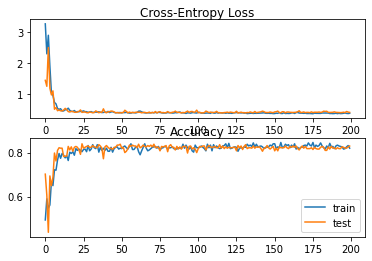

In [9]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

### Effects of Batch Size on Model Behavior

We can refit the model with different batch sizes and review the impact the change in batch size has on learning speed, stability during learning, and the final result.

We can create a function to fit a model on the problem with a given batch size and plot the learning curves of classification accuracy on the train and test datasets.

In [10]:
# fit a model and plot learning curve
def fit_model(trainX, trainy, testX, testy, n_batch):
    # define model
    model = Sequential()
    model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))

    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    # fit model
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=1, batch_size=n_batch)
    
    # plot learning curves
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.title('batch='+str(n_batch), pad=-40)

Finally, we can evaluate the model behavior with a suite of different batch sizes while holding everything else about the model constant, including the learning rate.

Epoch 1/200
125/125 [==============================] - 0s 2ms/step - loss: 3.5933 - accuracy: 0.4997 - val_loss: 0.7338 - val_accuracy: 0.7420
Epoch 2/200
125/125 [==============================] - 0s 2ms/step - loss: 0.7027 - accuracy: 0.7021 - val_loss: 0.4847 - val_accuracy: 0.8180
Epoch 3/200
125/125 [==============================] - 0s 2ms/step - loss: 0.5429 - accuracy: 0.7844 - val_loss: 0.5089 - val_accuracy: 0.8220
Epoch 4/200
125/125 [==============================] - 0s 2ms/step - loss: 0.5557 - accuracy: 0.7754 - val_loss: 0.4886 - val_accuracy: 0.8080
Epoch 5/200
125/125 [==============================] - 0s 2ms/step - loss: 0.5187 - accuracy: 0.8093 - val_loss: 0.4787 - val_accuracy: 0.8120
Epoch 6/200
125/125 [==============================] - 0s 2ms/step - loss: 0.5461 - accuracy: 0.7821 - val_loss: 0.5706 - val_accuracy: 0.7580
Epoch 7/200
125/125 [==============================] - 0s 2ms/step - loss: 0.5040 - accuracy: 0.7782 - val_loss: 0.4551 - val_accuracy: 0.8200

Epoch 58/200
125/125 [==============================] - 0s 2ms/step - loss: 0.4371 - accuracy: 0.8151 - val_loss: 0.4422 - val_accuracy: 0.8360
Epoch 59/200
125/125 [==============================] - 0s 2ms/step - loss: 0.4798 - accuracy: 0.8004 - val_loss: 0.4589 - val_accuracy: 0.8260
Epoch 60/200
125/125 [==============================] - 0s 2ms/step - loss: 0.4025 - accuracy: 0.8306 - val_loss: 0.5912 - val_accuracy: 0.7400
Epoch 61/200
125/125 [==============================] - 0s 2ms/step - loss: 0.4700 - accuracy: 0.7821 - val_loss: 0.4720 - val_accuracy: 0.8300
Epoch 62/200
125/125 [==============================] - 0s 2ms/step - loss: 0.4225 - accuracy: 0.8246 - val_loss: 0.4764 - val_accuracy: 0.8260
Epoch 63/200
125/125 [==============================] - 0s 2ms/step - loss: 0.4206 - accuracy: 0.8193 - val_loss: 0.4975 - val_accuracy: 0.8100
Epoch 64/200
125/125 [==============================] - 0s 2ms/step - loss: 0.4941 - accuracy: 0.7760 - val_loss: 0.4576 - val_accuracy:

Epoch 115/200
125/125 [==============================] - 0s 2ms/step - loss: 0.3968 - accuracy: 0.8066 - val_loss: 0.4671 - val_accuracy: 0.8180
Epoch 116/200
125/125 [==============================] - 0s 2ms/step - loss: 0.3980 - accuracy: 0.8513 - val_loss: 0.5021 - val_accuracy: 0.8180
Epoch 117/200
125/125 [==============================] - 0s 2ms/step - loss: 0.3744 - accuracy: 0.8404 - val_loss: 0.4747 - val_accuracy: 0.8180
Epoch 118/200
125/125 [==============================] - 0s 2ms/step - loss: 0.4784 - accuracy: 0.8008 - val_loss: 0.4563 - val_accuracy: 0.8220
Epoch 119/200
125/125 [==============================] - 0s 2ms/step - loss: 0.4128 - accuracy: 0.8020 - val_loss: 0.4448 - val_accuracy: 0.8240
Epoch 120/200
125/125 [==============================] - 0s 2ms/step - loss: 0.4273 - accuracy: 0.8193 - val_loss: 0.4547 - val_accuracy: 0.8340
Epoch 121/200
125/125 [==============================] - 0s 2ms/step - loss: 0.4168 - accuracy: 0.8042 - val_loss: 0.4931 - val_ac

125/125 [==============================] - 0s 2ms/step - loss: 0.4461 - accuracy: 0.8070 - val_loss: 0.4931 - val_accuracy: 0.8220
Epoch 172/200
125/125 [==============================] - 0s 2ms/step - loss: 0.3509 - accuracy: 0.8614 - val_loss: 0.4831 - val_accuracy: 0.8300
Epoch 173/200
125/125 [==============================] - 0s 2ms/step - loss: 0.3521 - accuracy: 0.8706 - val_loss: 0.5264 - val_accuracy: 0.7360
Epoch 174/200
125/125 [==============================] - 0s 2ms/step - loss: 0.4500 - accuracy: 0.7871 - val_loss: 0.4988 - val_accuracy: 0.8280
Epoch 175/200
125/125 [==============================] - 0s 2ms/step - loss: 0.4196 - accuracy: 0.8255 - val_loss: 0.4873 - val_accuracy: 0.8120
Epoch 176/200
125/125 [==============================] - 0s 2ms/step - loss: 0.4108 - accuracy: 0.8199 - val_loss: 0.4818 - val_accuracy: 0.8260
Epoch 177/200
125/125 [==============================] - 0s 2ms/step - loss: 0.3992 - accuracy: 0.8034 - val_loss: 0.4654 - val_accuracy: 0.8200

63/63 [==============================] - 0s 2ms/step - loss: 0.4313 - accuracy: 0.8256 - val_loss: 0.4288 - val_accuracy: 0.8280
Epoch 29/200
63/63 [==============================] - 0s 2ms/step - loss: 0.4130 - accuracy: 0.7828 - val_loss: 0.4342 - val_accuracy: 0.8220
Epoch 30/200
63/63 [==============================] - 0s 2ms/step - loss: 0.3821 - accuracy: 0.8219 - val_loss: 0.4206 - val_accuracy: 0.8220
Epoch 31/200
63/63 [==============================] - 0s 2ms/step - loss: 0.3788 - accuracy: 0.8489 - val_loss: 0.4210 - val_accuracy: 0.8140
Epoch 32/200
63/63 [==============================] - 0s 2ms/step - loss: 0.4084 - accuracy: 0.8361 - val_loss: 0.4248 - val_accuracy: 0.8380
Epoch 33/200
63/63 [==============================] - 0s 2ms/step - loss: 0.4367 - accuracy: 0.7745 - val_loss: 0.4251 - val_accuracy: 0.8220
Epoch 34/200
63/63 [==============================] - 0s 2ms/step - loss: 0.3818 - accuracy: 0.8518 - val_loss: 0.4200 - val_accuracy: 0.8280
Epoch 35/200
63/63 

Epoch 86/200
63/63 [==============================] - 0s 2ms/step - loss: 0.4004 - accuracy: 0.8018 - val_loss: 0.4305 - val_accuracy: 0.8220
Epoch 87/200
63/63 [==============================] - 0s 2ms/step - loss: 0.3972 - accuracy: 0.8296 - val_loss: 0.5014 - val_accuracy: 0.7940
Epoch 88/200
63/63 [==============================] - 0s 2ms/step - loss: 0.4121 - accuracy: 0.8285 - val_loss: 0.4899 - val_accuracy: 0.7860
Epoch 89/200
63/63 [==============================] - 0s 2ms/step - loss: 0.3830 - accuracy: 0.8563 - val_loss: 0.4508 - val_accuracy: 0.8180
Epoch 90/200
63/63 [==============================] - 0s 2ms/step - loss: 0.3887 - accuracy: 0.8253 - val_loss: 0.4497 - val_accuracy: 0.8180
Epoch 91/200
63/63 [==============================] - 0s 2ms/step - loss: 0.3971 - accuracy: 0.8235 - val_loss: 0.4650 - val_accuracy: 0.8160
Epoch 92/200
63/63 [==============================] - 0s 2ms/step - loss: 0.4473 - accuracy: 0.7764 - val_loss: 0.4210 - val_accuracy: 0.8320
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.3696 - accuracy: 0.8378 - val_loss: 0.4614 - val_accuracy: 0.8200
Epoch 144/200
63/63 [==============================] - 0s 3ms/step - loss: 0.4140 - accuracy: 0.8024 - val_loss: 0.4516 - val_accuracy: 0.8280
Epoch 145/200
63/63 [==============================] - 0s 2ms/step - loss: 0.4379 - accuracy: 0.8020 - val_loss: 0.4487 - val_accuracy: 0.8240
Epoch 146/200
63/63 [==============================] - 0s 2ms/step - loss: 0.4469 - accuracy: 0.8025 - val_loss: 0.4404 - val_accuracy: 0.8260
Epoch 147/200
63/63 [==============================] - 0s 2ms/step - loss: 0.4028 - accuracy: 0.8271 - val_loss: 0.4510 - val_accuracy: 0.8240
Epoch 148/200
63/63 [==============================] - 0s 2ms/step - loss: 0.3962 - accuracy: 0.8108 - val_loss: 0.4278 - val_accuracy: 0.8280
Epoch 149/200
63/63 [==============================] - 0s 2ms/step - loss: 0.3963 - accuracy: 0.8015 - val_loss: 0.4546 - val_accuracy: 0.8260
Epoch 150/200

63/63 [==============================] - 0s 2ms/step - loss: 0.4308 - accuracy: 0.8360 - val_loss: 0.4569 - val_accuracy: 0.8240
Epoch 1/200
32/32 [==============================] - 0s 5ms/step - loss: 4.0911 - accuracy: 0.4543 - val_loss: 4.4926 - val_accuracy: 0.5640
Epoch 2/200
32/32 [==============================] - 0s 3ms/step - loss: 3.1618 - accuracy: 0.6137 - val_loss: 0.9435 - val_accuracy: 0.6800
Epoch 3/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9868 - accuracy: 0.6573 - val_loss: 0.5933 - val_accuracy: 0.7520
Epoch 4/200
32/32 [==============================] - 0s 3ms/step - loss: 0.6714 - accuracy: 0.7092 - val_loss: 1.0617 - val_accuracy: 0.6580
Epoch 5/200
32/32 [==============================] - 0s 3ms/step - loss: 0.7243 - accuracy: 0.7477 - val_loss: 0.6954 - val_accuracy: 0.7080
Epoch 6/200
32/32 [==============================] - 0s 3ms/step - loss: 0.7478 - accuracy: 0.6815 - val_loss: 0.4632 - val_accuracy: 0.8100
Epoch 7/200
32/32 [======

Epoch 58/200
32/32 [==============================] - 0s 3ms/step - loss: 0.3918 - accuracy: 0.8385 - val_loss: 0.4287 - val_accuracy: 0.8360
Epoch 59/200
32/32 [==============================] - 0s 3ms/step - loss: 0.4285 - accuracy: 0.8194 - val_loss: 0.4110 - val_accuracy: 0.8360
Epoch 60/200
32/32 [==============================] - 0s 3ms/step - loss: 0.3781 - accuracy: 0.8444 - val_loss: 0.4337 - val_accuracy: 0.8200
Epoch 61/200
32/32 [==============================] - 0s 3ms/step - loss: 0.4166 - accuracy: 0.8403 - val_loss: 0.4374 - val_accuracy: 0.8260
Epoch 62/200
32/32 [==============================] - 0s 3ms/step - loss: 0.4350 - accuracy: 0.7971 - val_loss: 0.4171 - val_accuracy: 0.8200
Epoch 63/200
32/32 [==============================] - 0s 3ms/step - loss: 0.4190 - accuracy: 0.8141 - val_loss: 0.4288 - val_accuracy: 0.8240
Epoch 64/200
32/32 [==============================] - 0s 3ms/step - loss: 0.4469 - accuracy: 0.7862 - val_loss: 0.4639 - val_accuracy: 0.8040
Epoch 

32/32 [==============================] - 0s 2ms/step - loss: 0.3708 - accuracy: 0.8323 - val_loss: 0.4171 - val_accuracy: 0.8140
Epoch 116/200
32/32 [==============================] - 0s 2ms/step - loss: 0.3890 - accuracy: 0.8316 - val_loss: 0.4704 - val_accuracy: 0.8040
Epoch 117/200
32/32 [==============================] - 0s 3ms/step - loss: 0.3800 - accuracy: 0.8185 - val_loss: 0.4294 - val_accuracy: 0.8200
Epoch 118/200
32/32 [==============================] - 0s 3ms/step - loss: 0.4321 - accuracy: 0.8125 - val_loss: 0.4337 - val_accuracy: 0.8140
Epoch 119/200
32/32 [==============================] - 0s 2ms/step - loss: 0.3986 - accuracy: 0.8102 - val_loss: 0.4251 - val_accuracy: 0.8260
Epoch 120/200
32/32 [==============================] - 0s 5ms/step - loss: 0.4032 - accuracy: 0.8394 - val_loss: 0.4136 - val_accuracy: 0.8280
Epoch 121/200
32/32 [==============================] - 0s 2ms/step - loss: 0.3883 - accuracy: 0.8421 - val_loss: 0.4372 - val_accuracy: 0.8200
Epoch 122/200

32/32 [==============================] - 0s 2ms/step - loss: 0.3563 - accuracy: 0.8485 - val_loss: 0.4493 - val_accuracy: 0.8160
Epoch 173/200
32/32 [==============================] - 0s 2ms/step - loss: 0.3471 - accuracy: 0.8712 - val_loss: 0.4342 - val_accuracy: 0.8180
Epoch 174/200
32/32 [==============================] - 0s 2ms/step - loss: 0.3864 - accuracy: 0.8319 - val_loss: 0.4166 - val_accuracy: 0.8260
Epoch 175/200
32/32 [==============================] - 0s 2ms/step - loss: 0.3751 - accuracy: 0.8380 - val_loss: 0.4416 - val_accuracy: 0.8200
Epoch 176/200
32/32 [==============================] - 0s 2ms/step - loss: 0.3537 - accuracy: 0.8566 - val_loss: 0.4246 - val_accuracy: 0.8220
Epoch 177/200
32/32 [==============================] - 0s 2ms/step - loss: 0.3780 - accuracy: 0.8182 - val_loss: 0.4257 - val_accuracy: 0.8260
Epoch 178/200
32/32 [==============================] - 0s 2ms/step - loss: 0.3894 - accuracy: 0.8201 - val_loss: 0.4337 - val_accuracy: 0.8280
Epoch 179/200

16/16 [==============================] - 0s 4ms/step - loss: 0.4120 - accuracy: 0.8136 - val_loss: 0.4155 - val_accuracy: 0.8280
Epoch 30/200
16/16 [==============================] - 0s 4ms/step - loss: 0.4019 - accuracy: 0.8131 - val_loss: 0.4352 - val_accuracy: 0.8220
Epoch 31/200
16/16 [==============================] - 0s 4ms/step - loss: 0.4011 - accuracy: 0.8440 - val_loss: 0.4283 - val_accuracy: 0.8240
Epoch 32/200
16/16 [==============================] - 0s 4ms/step - loss: 0.4047 - accuracy: 0.8310 - val_loss: 0.4102 - val_accuracy: 0.8360
Epoch 33/200
16/16 [==============================] - 0s 8ms/step - loss: 0.4440 - accuracy: 0.8067 - val_loss: 0.4354 - val_accuracy: 0.8300
Epoch 34/200
16/16 [==============================] - 0s 4ms/step - loss: 0.3927 - accuracy: 0.8393 - val_loss: 0.4761 - val_accuracy: 0.8100
Epoch 35/200
16/16 [==============================] - 0s 4ms/step - loss: 0.4380 - accuracy: 0.8276 - val_loss: 0.4616 - val_accuracy: 0.8120
Epoch 36/200
16/16 

Epoch 87/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4030 - accuracy: 0.8148 - val_loss: 0.4291 - val_accuracy: 0.8220
Epoch 88/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4243 - accuracy: 0.8291 - val_loss: 0.4528 - val_accuracy: 0.8100
Epoch 89/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4122 - accuracy: 0.8448 - val_loss: 0.4219 - val_accuracy: 0.8240
Epoch 90/200
16/16 [==============================] - 0s 3ms/step - loss: 0.3812 - accuracy: 0.8407 - val_loss: 0.4135 - val_accuracy: 0.8160
Epoch 91/200
16/16 [==============================] - 0s 4ms/step - loss: 0.4184 - accuracy: 0.8274 - val_loss: 0.4217 - val_accuracy: 0.8220
Epoch 92/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4117 - accuracy: 0.8178 - val_loss: 0.4114 - val_accuracy: 0.8220
Epoch 93/200
16/16 [==============================] - 0s 4ms/step - loss: 0.3858 - accuracy: 0.8218 - val_loss: 0.4284 - val_accuracy: 0.8180
Epoch 

16/16 [==============================] - 0s 4ms/step - loss: 0.4394 - accuracy: 0.7978 - val_loss: 0.4544 - val_accuracy: 0.8040
Epoch 145/200
16/16 [==============================] - 0s 4ms/step - loss: 0.4017 - accuracy: 0.8098 - val_loss: 0.4264 - val_accuracy: 0.8100
Epoch 146/200
16/16 [==============================] - 0s 4ms/step - loss: 0.4163 - accuracy: 0.8135 - val_loss: 0.4231 - val_accuracy: 0.8260
Epoch 147/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4236 - accuracy: 0.8132 - val_loss: 0.4232 - val_accuracy: 0.8180
Epoch 148/200
16/16 [==============================] - 0s 3ms/step - loss: 0.3845 - accuracy: 0.8156 - val_loss: 0.4331 - val_accuracy: 0.8220
Epoch 149/200
16/16 [==============================] - 0s 4ms/step - loss: 0.3952 - accuracy: 0.8115 - val_loss: 0.4225 - val_accuracy: 0.8180
Epoch 150/200
16/16 [==============================] - 0s 3ms/step - loss: 0.3716 - accuracy: 0.8407 - val_loss: 0.4182 - val_accuracy: 0.8240
Epoch 151/200

8/8 [==============================] - 0s 29ms/step - loss: 4.0915 - accuracy: 0.4383 - val_loss: 5.1564 - val_accuracy: 0.4160
Epoch 2/200
8/8 [==============================] - 0s 6ms/step - loss: 3.6912 - accuracy: 0.4750 - val_loss: 2.7205 - val_accuracy: 0.6140
Epoch 3/200
8/8 [==============================] - 0s 6ms/step - loss: 2.9183 - accuracy: 0.5859 - val_loss: 1.5136 - val_accuracy: 0.6520
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 1.7486 - accuracy: 0.6092 - val_loss: 1.1345 - val_accuracy: 0.6320
Epoch 5/200
8/8 [==============================] - 0s 6ms/step - loss: 1.1488 - accuracy: 0.6159 - val_loss: 1.0055 - val_accuracy: 0.6840
Epoch 6/200
8/8 [==============================] - 0s 6ms/step - loss: 1.0765 - accuracy: 0.6168 - val_loss: 0.7757 - val_accuracy: 0.7080
Epoch 7/200
8/8 [==============================] - 0s 6ms/step - loss: 0.7807 - accuracy: 0.6842 - val_loss: 0.7422 - val_accuracy: 0.7100
Epoch 8/200
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.4364 - accuracy: 0.8186 - val_loss: 0.4032 - val_accuracy: 0.8320
Epoch 60/200
8/8 [==============================] - 0s 5ms/step - loss: 0.4034 - accuracy: 0.8341 - val_loss: 0.5014 - val_accuracy: 0.7960
Epoch 61/200
8/8 [==============================] - 0s 5ms/step - loss: 0.4765 - accuracy: 0.7934 - val_loss: 0.4203 - val_accuracy: 0.8240
Epoch 62/200
8/8 [==============================] - 0s 6ms/step - loss: 0.4407 - accuracy: 0.8049 - val_loss: 0.4228 - val_accuracy: 0.8280
Epoch 63/200
8/8 [==============================] - 0s 6ms/step - loss: 0.4562 - accuracy: 0.8019 - val_loss: 0.4351 - val_accuracy: 0.8200
Epoch 64/200
8/8 [==============================] - 0s 6ms/step - loss: 0.4471 - accuracy: 0.7985 - val_loss: 0.4365 - val_accuracy: 0.8220
Epoch 65/200
8/8 [==============================] - 0s 6ms/step - loss: 0.3969 - accuracy: 0.8457 - val_loss: 0.4013 - val_accuracy: 0.8360
Epoch 66/200
8/8 [===============

8/8 [==============================] - 0s 5ms/step - loss: 0.3746 - accuracy: 0.8423 - val_loss: 0.4044 - val_accuracy: 0.8220
Epoch 118/200
8/8 [==============================] - 0s 6ms/step - loss: 0.4439 - accuracy: 0.7978 - val_loss: 0.4172 - val_accuracy: 0.8260
Epoch 119/200
8/8 [==============================] - 0s 6ms/step - loss: 0.4077 - accuracy: 0.8374 - val_loss: 0.4057 - val_accuracy: 0.8200
Epoch 120/200
8/8 [==============================] - 0s 6ms/step - loss: 0.4010 - accuracy: 0.8547 - val_loss: 0.4363 - val_accuracy: 0.8320
Epoch 121/200
8/8 [==============================] - 0s 6ms/step - loss: 0.3990 - accuracy: 0.8296 - val_loss: 0.4037 - val_accuracy: 0.8320
Epoch 122/200
8/8 [==============================] - 0s 6ms/step - loss: 0.3648 - accuracy: 0.8474 - val_loss: 0.4256 - val_accuracy: 0.8180
Epoch 123/200
8/8 [==============================] - 0s 6ms/step - loss: 0.4068 - accuracy: 0.8114 - val_loss: 0.4082 - val_accuracy: 0.8220
Epoch 124/200
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.3755 - accuracy: 0.8302 - val_loss: 0.4414 - val_accuracy: 0.8260
Epoch 176/200
8/8 [==============================] - 0s 6ms/step - loss: 0.3616 - accuracy: 0.8418 - val_loss: 0.4065 - val_accuracy: 0.8340
Epoch 177/200
8/8 [==============================] - 0s 6ms/step - loss: 0.3857 - accuracy: 0.8180 - val_loss: 0.4193 - val_accuracy: 0.8200
Epoch 178/200
8/8 [==============================] - 0s 6ms/step - loss: 0.3735 - accuracy: 0.8338 - val_loss: 0.4260 - val_accuracy: 0.8360
Epoch 179/200
8/8 [==============================] - 0s 17ms/step - loss: 0.4275 - accuracy: 0.8275 - val_loss: 0.4141 - val_accuracy: 0.8240
Epoch 180/200
8/8 [==============================] - 0s 6ms/step - loss: 0.3827 - accuracy: 0.8307 - val_loss: 0.4233 - val_accuracy: 0.8240
Epoch 181/200
8/8 [==============================] - 0s 6ms/step - loss: 0.3786 - accuracy: 0.8545 - val_loss: 0.4298 - val_accuracy: 0.8200
Epoch 182/200
8/8 [=======

4/4 [==============================] - 0s 12ms/step - loss: 0.5166 - accuracy: 0.7747 - val_loss: 0.4921 - val_accuracy: 0.8200
Epoch 34/200
4/4 [==============================] - 0s 11ms/step - loss: 0.5098 - accuracy: 0.7867 - val_loss: 0.4896 - val_accuracy: 0.8000
Epoch 35/200
4/4 [==============================] - 0s 12ms/step - loss: 0.5253 - accuracy: 0.7647 - val_loss: 0.4922 - val_accuracy: 0.7940
Epoch 36/200
4/4 [==============================] - 0s 12ms/step - loss: 0.5011 - accuracy: 0.7792 - val_loss: 0.4739 - val_accuracy: 0.8240
Epoch 37/200
4/4 [==============================] - 0s 11ms/step - loss: 0.5041 - accuracy: 0.7722 - val_loss: 0.5870 - val_accuracy: 0.7360
Epoch 38/200
4/4 [==============================] - 0s 11ms/step - loss: 0.5559 - accuracy: 0.7160 - val_loss: 0.4924 - val_accuracy: 0.8180
Epoch 39/200
4/4 [==============================] - 0s 11ms/step - loss: 0.5329 - accuracy: 0.7678 - val_loss: 0.5046 - val_accuracy: 0.7840
Epoch 40/200
4/4 [========

4/4 [==============================] - 0s 11ms/step - loss: 0.4277 - accuracy: 0.8170 - val_loss: 0.4108 - val_accuracy: 0.8320
Epoch 92/200
4/4 [==============================] - 0s 12ms/step - loss: 0.4332 - accuracy: 0.8129 - val_loss: 0.4539 - val_accuracy: 0.8180
Epoch 93/200
4/4 [==============================] - 0s 11ms/step - loss: 0.4309 - accuracy: 0.8060 - val_loss: 0.4108 - val_accuracy: 0.8320
Epoch 94/200
4/4 [==============================] - 0s 11ms/step - loss: 0.4209 - accuracy: 0.8254 - val_loss: 0.4084 - val_accuracy: 0.8360
Epoch 95/200
4/4 [==============================] - 0s 12ms/step - loss: 0.4321 - accuracy: 0.8291 - val_loss: 0.4162 - val_accuracy: 0.8280
Epoch 96/200
4/4 [==============================] - 0s 12ms/step - loss: 0.4060 - accuracy: 0.8152 - val_loss: 0.4212 - val_accuracy: 0.8280
Epoch 97/200
4/4 [==============================] - 0s 13ms/step - loss: 0.4358 - accuracy: 0.8202 - val_loss: 0.4075 - val_accuracy: 0.8380
Epoch 98/200
4/4 [========

Epoch 149/200
4/4 [==============================] - 0s 11ms/step - loss: 0.3859 - accuracy: 0.8305 - val_loss: 0.4062 - val_accuracy: 0.8280
Epoch 150/200
4/4 [==============================] - 0s 11ms/step - loss: 0.3827 - accuracy: 0.8377 - val_loss: 0.4156 - val_accuracy: 0.8280
Epoch 151/200
4/4 [==============================] - 0s 12ms/step - loss: 0.3644 - accuracy: 0.8416 - val_loss: 0.4060 - val_accuracy: 0.8300
Epoch 152/200
4/4 [==============================] - 0s 37ms/step - loss: 0.3908 - accuracy: 0.8221 - val_loss: 0.4116 - val_accuracy: 0.8300
Epoch 153/200
4/4 [==============================] - 0s 11ms/step - loss: 0.4083 - accuracy: 0.8409 - val_loss: 0.4097 - val_accuracy: 0.8240
Epoch 154/200
4/4 [==============================] - 0s 11ms/step - loss: 0.3740 - accuracy: 0.8426 - val_loss: 0.4037 - val_accuracy: 0.8340
Epoch 155/200
4/4 [==============================] - 0s 11ms/step - loss: 0.4020 - accuracy: 0.8215 - val_loss: 0.4411 - val_accuracy: 0.8160
Epoch 

Epoch 7/200
2/2 [==============================] - 0s 31ms/step - loss: 1.9850 - accuracy: 0.5979 - val_loss: 2.8608 - val_accuracy: 0.5220
Epoch 8/200
2/2 [==============================] - 0s 29ms/step - loss: 2.4529 - accuracy: 0.5466 - val_loss: 1.9104 - val_accuracy: 0.6200
Epoch 9/200
2/2 [==============================] - 0s 29ms/step - loss: 2.1653 - accuracy: 0.5887 - val_loss: 1.6244 - val_accuracy: 0.6420
Epoch 10/200
2/2 [==============================] - 0s 34ms/step - loss: 1.6564 - accuracy: 0.6166 - val_loss: 1.8755 - val_accuracy: 0.5260
Epoch 11/200
2/2 [==============================] - 0s 29ms/step - loss: 1.7175 - accuracy: 0.5439 - val_loss: 1.5898 - val_accuracy: 0.6560
Epoch 12/200
2/2 [==============================] - 0s 28ms/step - loss: 1.7342 - accuracy: 0.6047 - val_loss: 1.0541 - val_accuracy: 0.6920
Epoch 13/200
2/2 [==============================] - 0s 29ms/step - loss: 1.2655 - accuracy: 0.6174 - val_loss: 0.9287 - val_accuracy: 0.7080
Epoch 14/200
2/2

2/2 [==============================] - 0s 33ms/step - loss: 0.5356 - accuracy: 0.7778 - val_loss: 0.5031 - val_accuracy: 0.7920
Epoch 66/200
2/2 [==============================] - 0s 29ms/step - loss: 0.5452 - accuracy: 0.7474 - val_loss: 0.4994 - val_accuracy: 0.8080
Epoch 67/200
2/2 [==============================] - 0s 31ms/step - loss: 0.5234 - accuracy: 0.7871 - val_loss: 0.5023 - val_accuracy: 0.8260
Epoch 68/200
2/2 [==============================] - 0s 29ms/step - loss: 0.4966 - accuracy: 0.7987 - val_loss: 0.4976 - val_accuracy: 0.7960
Epoch 69/200
2/2 [==============================] - 0s 31ms/step - loss: 0.5326 - accuracy: 0.7740 - val_loss: 0.5040 - val_accuracy: 0.8240
Epoch 70/200
2/2 [==============================] - 0s 29ms/step - loss: 0.5059 - accuracy: 0.7884 - val_loss: 0.4960 - val_accuracy: 0.7920
Epoch 71/200
2/2 [==============================] - 0s 28ms/step - loss: 0.5156 - accuracy: 0.7765 - val_loss: 0.5024 - val_accuracy: 0.8260
Epoch 72/200
2/2 [========

2/2 [==============================] - 0s 28ms/step - loss: 0.4454 - accuracy: 0.8095 - val_loss: 0.4541 - val_accuracy: 0.8300
Epoch 124/200
2/2 [==============================] - 0s 28ms/step - loss: 0.4633 - accuracy: 0.8149 - val_loss: 0.4422 - val_accuracy: 0.8120
Epoch 125/200
2/2 [==============================] - 0s 32ms/step - loss: 0.4623 - accuracy: 0.8017 - val_loss: 0.4668 - val_accuracy: 0.8240
Epoch 126/200
2/2 [==============================] - 0s 28ms/step - loss: 0.4589 - accuracy: 0.8266 - val_loss: 0.4595 - val_accuracy: 0.8020
Epoch 127/200
2/2 [==============================] - 0s 102ms/step - loss: 0.5035 - accuracy: 0.7790 - val_loss: 0.4337 - val_accuracy: 0.8300
Epoch 128/200
2/2 [==============================] - 0s 28ms/step - loss: 0.4752 - accuracy: 0.7963 - val_loss: 0.4381 - val_accuracy: 0.8320
Epoch 129/200
2/2 [==============================] - 0s 28ms/step - loss: 0.4805 - accuracy: 0.7842 - val_loss: 0.4464 - val_accuracy: 0.8100
Epoch 130/200
2/2 [

Epoch 181/200
2/2 [==============================] - 0s 28ms/step - loss: 0.4121 - accuracy: 0.8345 - val_loss: 0.4103 - val_accuracy: 0.8260
Epoch 182/200
2/2 [==============================] - 0s 28ms/step - loss: 0.4300 - accuracy: 0.8133 - val_loss: 0.4098 - val_accuracy: 0.8360
Epoch 183/200
2/2 [==============================] - 0s 30ms/step - loss: 0.4138 - accuracy: 0.8293 - val_loss: 0.4536 - val_accuracy: 0.8200
Epoch 184/200
2/2 [==============================] - 0s 34ms/step - loss: 0.4372 - accuracy: 0.8307 - val_loss: 0.4096 - val_accuracy: 0.8320
Epoch 185/200
2/2 [==============================] - 0s 29ms/step - loss: 0.4157 - accuracy: 0.8162 - val_loss: 0.4252 - val_accuracy: 0.8300
Epoch 186/200
2/2 [==============================] - 0s 33ms/step - loss: 0.4029 - accuracy: 0.8397 - val_loss: 0.4094 - val_accuracy: 0.8280
Epoch 187/200
2/2 [==============================] - 0s 29ms/step - loss: 0.4074 - accuracy: 0.8319 - val_loss: 0.4077 - val_accuracy: 0.8320
Epoch 

2/2 [==============================] - 0s 33ms/step - loss: 0.6879 - accuracy: 0.6307 - val_loss: 0.6790 - val_accuracy: 0.7100
Epoch 40/200
2/2 [==============================] - 0s 29ms/step - loss: 0.7269 - accuracy: 0.6542 - val_loss: 0.5579 - val_accuracy: 0.7840
Epoch 41/200
2/2 [==============================] - 0s 30ms/step - loss: 0.5666 - accuracy: 0.7474 - val_loss: 0.5878 - val_accuracy: 0.7460
Epoch 42/200
2/2 [==============================] - 0s 29ms/step - loss: 0.6056 - accuracy: 0.7185 - val_loss: 0.6272 - val_accuracy: 0.7260
Epoch 43/200
2/2 [==============================] - 0s 33ms/step - loss: 0.6500 - accuracy: 0.7087 - val_loss: 0.6836 - val_accuracy: 0.7220
Epoch 44/200
2/2 [==============================] - 0s 29ms/step - loss: 0.6584 - accuracy: 0.7142 - val_loss: 0.6550 - val_accuracy: 0.7260
Epoch 45/200
2/2 [==============================] - 0s 33ms/step - loss: 0.6917 - accuracy: 0.6843 - val_loss: 0.5344 - val_accuracy: 0.7940
Epoch 46/200
2/2 [========

2/2 [==============================] - 0s 102ms/step - loss: 0.4611 - accuracy: 0.8077 - val_loss: 0.4607 - val_accuracy: 0.8160
Epoch 98/200
2/2 [==============================] - 0s 29ms/step - loss: 0.4744 - accuracy: 0.7861 - val_loss: 0.4633 - val_accuracy: 0.8240
Epoch 99/200
2/2 [==============================] - 0s 29ms/step - loss: 0.4522 - accuracy: 0.8099 - val_loss: 0.4643 - val_accuracy: 0.8160
Epoch 100/200
2/2 [==============================] - 0s 29ms/step - loss: 0.4684 - accuracy: 0.7898 - val_loss: 0.5023 - val_accuracy: 0.8100
Epoch 101/200
2/2 [==============================] - 0s 33ms/step - loss: 0.4860 - accuracy: 0.8076 - val_loss: 0.4825 - val_accuracy: 0.8220
Epoch 102/200
2/2 [==============================] - 0s 35ms/step - loss: 0.4661 - accuracy: 0.8166 - val_loss: 0.4537 - val_accuracy: 0.8220
Epoch 103/200
2/2 [==============================] - 0s 29ms/step - loss: 0.4702 - accuracy: 0.7978 - val_loss: 0.4640 - val_accuracy: 0.8160
Epoch 104/200
2/2 [==

Epoch 155/200
2/2 [==============================] - 0s 30ms/step - loss: 0.4509 - accuracy: 0.8241 - val_loss: 0.4568 - val_accuracy: 0.8100
Epoch 156/200
2/2 [==============================] - 0s 29ms/step - loss: 0.4927 - accuracy: 0.7800 - val_loss: 0.4385 - val_accuracy: 0.8080
Epoch 157/200
2/2 [==============================] - 0s 29ms/step - loss: 0.4386 - accuracy: 0.8107 - val_loss: 0.4301 - val_accuracy: 0.8220
Epoch 158/200
2/2 [==============================] - 0s 29ms/step - loss: 0.4177 - accuracy: 0.8227 - val_loss: 0.5346 - val_accuracy: 0.7860
Epoch 159/200
2/2 [==============================] - 0s 29ms/step - loss: 0.5923 - accuracy: 0.7621 - val_loss: 0.4486 - val_accuracy: 0.8140
Epoch 160/200
2/2 [==============================] - 0s 34ms/step - loss: 0.4589 - accuracy: 0.7908 - val_loss: 0.5848 - val_accuracy: 0.7460
Epoch 161/200
2/2 [==============================] - 0s 29ms/step - loss: 0.5461 - accuracy: 0.7418 - val_loss: 0.4838 - val_accuracy: 0.8000
Epoch 

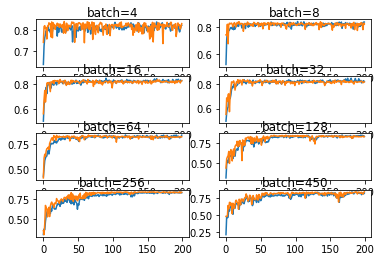

In [11]:
# prepare dataset
trainX, trainy, testX, testy = create_dataset()

# create learning curves for different batch sizes
batch_sizes = [4, 8, 16, 32, 64, 128, 256, 450]

for i in range(len(batch_sizes)):
    # determine the plot number
    plot_no = 420 + (i+1)
    pyplot.subplot(plot_no)
    
    # fit model and plot learning curves for a batch size
    fit_model(trainX, trainy, testX, testy, batch_sizes[i])   
    
# show learning curves
pyplot.show()

The result will be a figure with eight plots of model behavior with eight different batch sizes.

Running the example creates a figure with eight-line plots showing the classification accuracy on the train and test sets of models with different batch sizes when using minibatch gradient descent.

**Note**: Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

The plots show that small-batch results generally in rapid learning but a volatile learning process with higher variance in the classification accuracy. Larger batch sizes slow down the learning process (in terms of the learning curves), but the final stages result in a convergence to a more stable model exemplified by lower variance in classification accuracy.

**Extensions**

This section lists some ideas for extending the tutorial that you may wish to explore.
* **Vary Learning Rate**. Study the effect of different learning rate values on a logarithmic scale with stochastic (online) gradient descent.
* **Vary Epochs**. Study the number of epochs required for convergence as the batch size is increased to the training dataset size with minibatch gradient descent.

**Summary**

In this tutorial, you discovered three different flavors of gradient descent and how to explore and diagnose the effect of batch size on the learning process. Specifically, you learned:
* Batch size controls the accuracy of the estimate of the error gradient when training neural networks.
* Batch, Stochastic, and Minibatch gradient descent are the three main flavors of the learning algorithm.
* There is a tension between batch size and the speed and stability of the learning process.